In [1]:
import pandas as pd
df = pd.read_csv('topic.csv')
df.head()
col = ['annotation', 'title','body']
df = df[col]
df['category_id'] = df['annotation'].factorize()[0]
from io import StringIO
category_id_df = df[['annotation', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'annotation']].values)
labels = df.category_id
print(category_id_df)

                  annotation  category_id
0                   Business            0
204            Entertainment            1
617                    Error            2
646                   Health            3
721                    Other            4
765                 Politics            5
1104  Science and Technology            6
1233                 Society            7
1925                  Sports            8
2213                     War            9


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(df.body)

In [22]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

kfold = model_selection.KFold(n_splits=10, random_state=7)
sfolder = StratifiedKFold(n_splits=10,random_state=0)
modelCV = LogisticRegression(C=1e5,class_weight='balanced')
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, bag_of_words, labels, cv=sfolder, scoring=scoring)
for i in results:
    print("%.4f",i)
print("10-fold cross validation average accuracy: %.4f" % (results.mean()))

%.4f 0.6523605150214592
%.4f 0.6637931034482759
%.4f 0.6753246753246753
%.4f 0.6956521739130435
%.4f 0.6535087719298246
%.4f 0.7048458149779736
%.4f 0.6475770925110133
%.4f 0.6387665198237885
%.4f 0.6858407079646017
%.4f 0.6681614349775785
10-fold cross validation average accuracy: 0.6686


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(df.body,labels,random_state = 0,test_size = 0.2)
vectorizer.fit(df.body)
train_features = vectorizer.transform(X_train)
test_features = vectorizer.transform(X_test)

logreg = LogisticRegression(C=1e5, class_weight='balanced')
logreg.fit(train_features, y_train)
y_pred = logreg.predict(test_features)

print('Accuracy of logistic regression classifier on test set: {:.6f}'.format(logreg.score(test_features, y_test)))

Accuracy of logistic regression classifier on test set: 0.669584


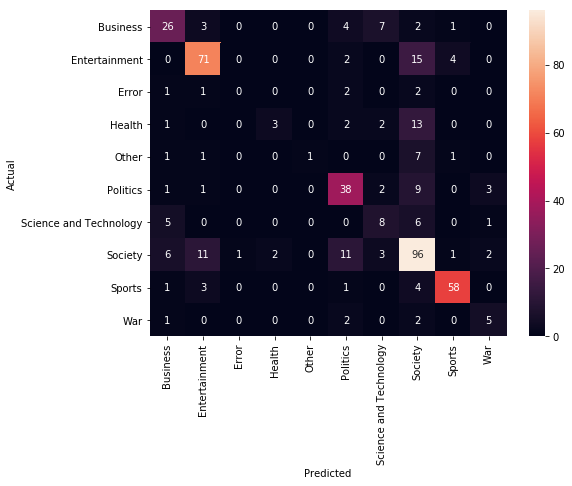

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat   
df_cm = pd.DataFrame(conf_mat)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt='d', xticklabels=category_id_df.annotation.values, yticklabels=category_id_df.annotation.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [24]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['annotation'].unique()))

                        precision    recall  f1-score   support

              Business       0.60      0.60      0.60        43
         Entertainment       0.78      0.77      0.78        92
                 Error       0.00      0.00      0.00         6
                Health       0.60      0.14      0.23        21
                 Other       1.00      0.09      0.17        11
              Politics       0.61      0.70      0.66        54
Science and Technology       0.36      0.40      0.38        20
               Society       0.62      0.72      0.66       133
                Sports       0.89      0.87      0.88        67
                   War       0.45      0.50      0.48        10

           avg / total       0.67      0.67      0.65       457



In [36]:
from sklearn.feature_selection import chi2
import numpy as np
N = 10
for annotation, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(bag_of_words, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print(" '{}':".format(annotation),end='')
    print(" {}".format('. '.join(unigrams[-N:])),end='')
    print('')

 'Business': company. its. per. apple. investors. growth. prices. sale. market. iphone
 'Entertainment': movie. music. actor. class. star. div. she. show. film. her
 'Error': href. li. www. ad. http. span. cuomo. ew. class. div
 'Health': sorcha. polio. diet. kushi. genes. cancer. pathways. anxiety. kuencer. ebola
 'Other': vyom. hai. kaa. pope. your. gorringe. bradfield. you. pancakes. apicius
 'Politics': congress. senate. bjp. modi. election. minister. party. government. president. obama
 'Science and Technology': galaxy. space. jetstar. doors. 4g. keyboard. technology. scientists. android. nasa
 'Society': hospital. was. were. ew. said. class. game. div. officers. police
 'Sports': san. inning. francisco. players. team. nlcs. cardinals. giants. league. game
 'War': syrian. al. military. ukraine. iraq. syria. ukrainian. troops. forces. islamic


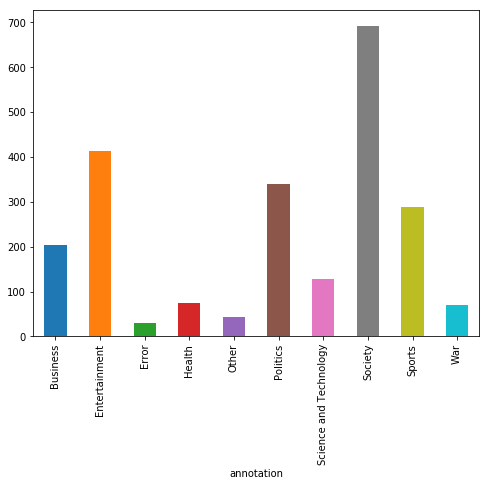

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('annotation').body.count().plot.bar(ylim=0)
plt.show()